In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from joblib import load
from cleantext.clean import clean
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import swifter

# initialize tqdm
tqdm.pandas()

In [ ]:
# Load and preprocess the content
df = pd.read_csv('data/liar_dataset/train.tsv', sep='\t', header=None)

def clean_space(txt):
    return clean(str(txt), 
                 fix_unicode=True, 
                 to_ascii=True, 
                 lower=True, 
                 no_line_breaks=True,
                 lang="en")

patterns = {
    r"[\w]+ [\d]+, [\d]+": "",                     # DATE method 1: "January 15, 2023"
    r"[\d]+[\w]+ [\w]+ [\d]+": "",                 # DATE method 2: "15th January 2023" 
    r"[\d]+\/?-?\.?[\d]+\/?-?\.?[\d]+": "",        # DATE method 3: "01/15/2023", "01-15-2023", "01.15.2023"
    r"[\w]+ \d\d?[\w]?[\w]?,? [\d]{2,4}": "",      # DATE method 4: "January 15th, 2023", "Jan 1, 2023"
    r"([\d]{1,2}[\w]*) ([\w]*),? ([\d]{2,4})": "", # DATE method 5: "15 January, 2023", capturing day, month, year
    r"\b(\d+(st|nd|rd|th|s))\b": ""                # NUM: Ordinal numbers like "1st", "2nd", "3rd", "4th" or plural suffixes
}
# Creates a list of tuples containing compiled_regex and replacement_string
compiled_patterns = [(re.compile(pattern), replacement) for pattern, replacement in patterns.items()]

# Function that remove all date patterns from the text 
def remove_dates(txt):
    for pattern, replacement in compiled_patterns:
        txt = re.sub(pattern, replacement, txt)
    return txt

def remove_urls(txt):
    return clean(txt, 
        no_urls=True,                    # Remove all URLs from text
        no_emails=True,                  # Remove email addresses
        no_phone_numbers=True,           # Remove phone number patterns
        no_numbers=True,                 # Remove standalone numbers
        no_digits=True,                  # Remove individual digits
        no_currency_symbols=True,        # Remove currency symbols like $, €, etc.
        lower=False,                     # Preserve original case 
        no_punct=True,                   # Remove all punctuation
        replace_with_punct="",           # Replace punctuation with empty string
        replace_with_url="URL",          # Replace URLs with the token "URL"
        replace_with_email="EMAIL",      # Replace emails with the token "EMAIL"
        replace_with_phone_number="",    # Replace phone numbers with empty string
        replace_with_number="NUM",       # Replace numbers with the token "NUM"
        replace_with_digit="0",          # Replace digits with "0"
        replace_with_currency_symbol="", # Replace currency symbols with empty string
        lang="en"                        # Process as English language text
    )

stop_words = set(stopwords.words('english'))

# Function to filter out stop words from a list of tokens
def remove_stop_words(lst):
    # The list comprehension keeps only words that are not in the stop_words set
    return [word for word in lst if word.lower() not in stop_words]

# Initialize the Porter Stemming algorithm which reduces words to their root/base form
stemmer = PorterStemmer()
def stemming(lst):
    # Each word is reduced to its stem using the Porter algorithm
    return [stemmer.stem(word) for word in lst]



# Apply the clean_space function to each row in the content column
df[2] = df[2].astype(str).swifter.progress_bar(True).apply(clean_space)
# Apply the date removal function to each row in the content column
df[2] = df[2].astype(str).swifter.progress_bar(True).apply(remove_dates)
# Apply text cleaning to remove specific elements from each document
# Using swifter to parallelize processing for better performance
df[2] = df[2].astype(str).swifter.progress_bar(True).apply(remove_urls)
# Apply the word tokenize function to each row in the content column
df[2] = df[2].astype(str).swifter.progress_bar(True).apply(word_tokenize)
# Remove stop words from each article in the Fake news dataset
df[2] = df[2].swifter.progress_bar(True).apply(remove_stop_words)
# Apply stemming to each article in the dataset
df[2] = df[2].swifter.progress_bar(True).apply(stemming)

label_map = {"half-true": 1, "false":1, "barely-true": 1, "pants-fire": 1,
             "true": 0, "mostly-true": 0} 
df = df[df[1].isin(label_map.keys())]  # Keep only rows with valid labels
df[1] = df[1].map(label_map)

# Load the vecorizers
BoWvextorizer = load('models/BoWvectorizer.joblib')
TFIDFvectorizer = load('models/tfidf_vectorizer.joblib')

Pandas Apply: 100%|██████████| 10240/10240 [00:00<00:00, 18651.58it/s]


In [9]:
# Function to create a confusion matrix 
def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))

    plt.title('Confusion Matrix')
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    

Pandas Apply: 100%|██████████| 10240/10240 [00:00<00:00, 2788758.71it/s]

LogisticRegression MSE:  0.35537109375
LogisticRegression accuracy:  0.64462890625
LogisticRegression F1 score:  0.7838431838431839


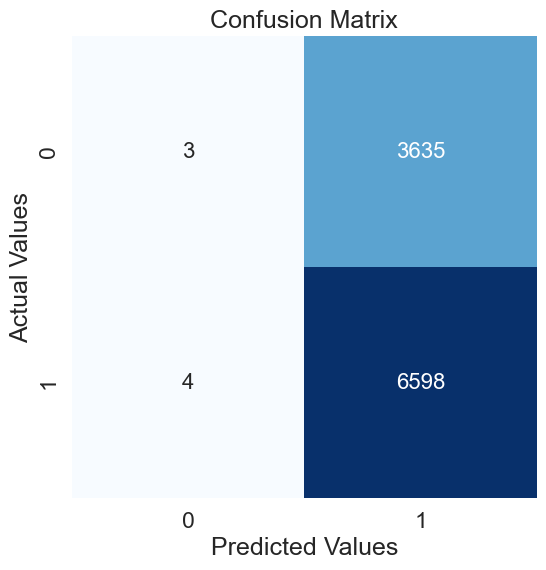

In [ ]:
# Evaluate the first logistic regression model
input_path = "models/logistic_regression_classifier.joblib"
model = load(input_path)

# Transform the text data to the correct format
X = BoWvextorizer.transform(df[2].swifter.progress_bar(True).apply(lambda x: ' '.join(x)))
y = df[1]

# Evaluate the model
y_pred = model.predict(X)
mse = ((y-y_pred)**2).mean()

print("LogisticRegression MSE: ", mse)
print("LogisticRegression accuracy: ", accuracy_score(y, y_pred))
print("LogisticRegression F1 score: ", f1_score(y, y_pred))
conf_matrix(y, y_pred)


In [ ]:
# Load the NN model
input_path = "models/nn_classifier.keras"
NN = tf.keras.models.load_model(input_path)

# Transform the text data to the correct format
X = TFIDFvectorizer.transform(df[2].swifter.progress_bar(True).apply(lambda x: ' '.join(x)))
y = df[1]

test_results = NN.evaluate(X, y, verbose=1, batch_size=128)
print(f"* Test Loss: {test_results[0]:.4f}")
print(f"* Test Accuracy: {test_results[1]:.4f}")
print(f"* Test Precision: {test_results[2]:.4f}")
print(f"* Test Recall: {test_results[3]:.4f}")
print(f"* Test AUC: {test_results[4]:.4f}")
print(f"* Test F1 Score: {test_results[5]:.4f}")

Pandas Apply: 100%|██████████| 10240/10240 [00:00<00:00, 2339944.05it/s]


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_score: 0.7785 - loss: 3.7337 - precision_1: 0.6387 - recall_1: 0.9392 - weighted_f1_score: 0.7785
* Test Loss: 3.6800
* Test Accuracy: 0.6440
* Test Precision: 0.9393
* Test Recall: 0.7833
* Test AUC: 0.7833
* Test F1 Score: 0.7833


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LogisticRegression MSE:  0.3739257752895355
LogisticRegression accuracy:  0.62607421875
LogisticRegression F1 score:  0.7640934015156182


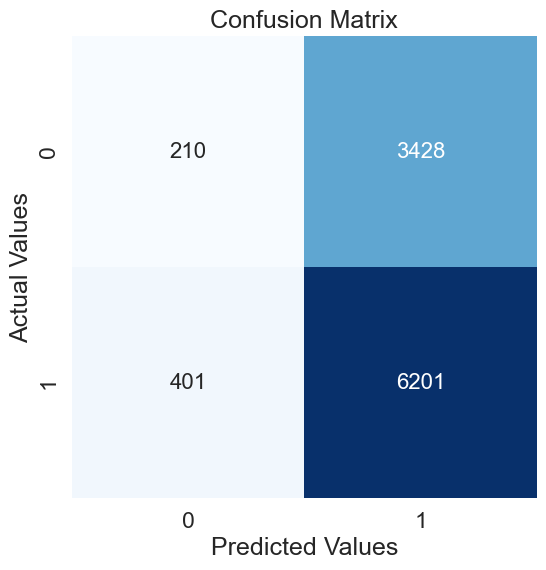

In [12]:
y_pred = NN.predict(X, batch_size=128)
y_pred = np.round(y_pred).flatten()

print("LogisticRegression MSE: ", mean_squared_error(y, y_pred))
print("LogisticRegression accuracy: ", accuracy_score(y, y_pred))
print("LogisticRegression F1 score: ", f1_score(y, y_pred))
conf_matrix(y, y_pred)